In [1]:
using Turing
using StatsPlots

```javascript
var locationPrior = function() {
  if (flip(.55)) {
    return 'popular-bar';
  } else {
    return 'unpopular-bar';
  }
};

var alice = function() {
  return Infer({ model() {
    var myLocation = locationPrior();
    return myLocation;
  }});
};

viz(alice());
```

In [2]:
P = 0.55

@model function alice0()
	myLocation ~ Bernoulli(P)
end

alice0 (generic function with 1 method)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


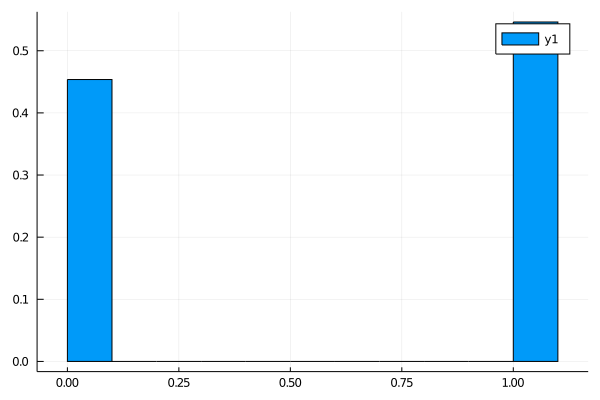

In [3]:
N = 10000
INFALG = IS()
# INFALG = MH()
# INFALG = PG(10)

#  Run sampler, collect results
chn0 = sample(alice0(), INFALG, N)

# Plot the results
function plotChn(chn)
    histogram(chn[:myLocation], weights=exp.(chn[:lp]), normalize=:probability)
end
plotChn(chn0)

```javascript
var alice = function() {
  return Infer({ model() {
    var myLocation = locationPrior();
    var bobLocation = sample(bob());
    condition(myLocation === bobLocation);
    return myLocation;
  }});
};

var bob = function() {
  return Infer({ model() {
    var myLocation = locationPrior();
    return myLocation;
  }});
};

viz(alice());
```

In [4]:
PDIRAC = 0.95

@model function alice1(bobChn)
    myLocation ~ Bernoulli(P)
    weights = exp.(bobChn[:lp][:, 1])
    idx ~ Categorical(weights/sum(weights))
    # Dirac can be used, but Bernoulli will give better convergence
    bobChn[:myLocation][idx, 1] ~ Bernoulli(myLocation ? PDIRAC : 1 - PDIRAC) # Dirac(myLocation)
end    
   

@model function bob1()
    myLocation ~ Bernoulli(P)
end

bob1 (generic function with 1 method)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


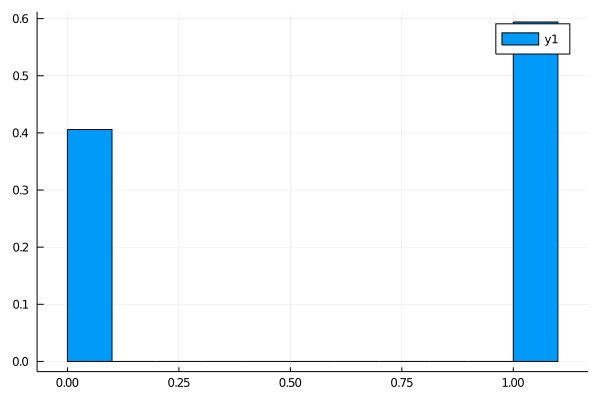

In [5]:
#  Run sampler, collect results
bobChn = sample(bob1(), INFALG, N)
chn1 = sample(alice1(bobChn), INFALG, N)

plotChn(chn1)

# Nested modeling

## Naive - without optimizations

In [6]:
N = 100

100

In [7]:
@model function alice_2(other_person_place, depth = 0)
    myLocation ~ Bernoulli(P)
    bob_chn = sample(other_person_place(alice_2, depth - 1), IS(), N)
    weights = exp.(bob_chn[:lp][:, 1])
    idx ~ Categorical(weights/sum(weights))
    # Dirac can be used, but Bernoulli will give better convergence
    bob_chn[:myLocation][idx, 1] ~ Bernoulli(myLocation ? PDIRAC : 1 - PDIRAC) # Dirac(myLocation)
end

alice_2 (generic function with 2 methods)

In [8]:
@model function bob_2(other_person_place, depth = 0)
    myLocation ~ Bernoulli(P)
    if depth == 0
       return myLocation 
    else
        alice_chn = sample(other_person_place(bob_2, depth), IS(), N)
        weights = exp.(alice_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        # Dirac can be used, but Bernoulli will give better convergence
        alice_chn[:myLocation][idx, 1] ~ Bernoulli(myLocation ? PDIRAC : 1 - PDIRAC) # Dirac(myLocation)
    end
end

bob_2 (generic function with 2 methods)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


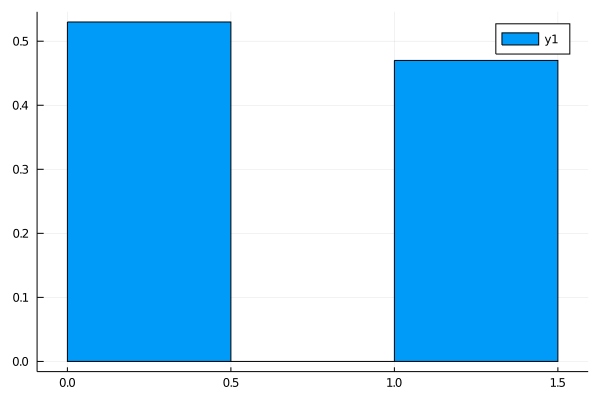

In [9]:
#  Run sampler, collect results
chn1 = sample(alice_2(bob_2, 1), INFALG, N)

plotChn(chn1)

## With Optmizations - Dynamic Programming

In [10]:
N = 10000

10000

In [11]:
@model function alice_2(bob_chn, depth = 0)
    myLocation ~ Bernoulli(P)
    weights = exp.(bob_chn[:lp][:, 1])
    idx ~ Categorical(weights/sum(weights))
    # Dirac can be used, but Bernoulli will give better convergence
    bob_chn[:myLocation][idx, 1] ~ Bernoulli(myLocation ? PDIRAC : 1 - PDIRAC) # Dirac(myLocation)
end

alice_2 (generic function with 2 methods)

In [12]:
@model function bob_2(alice_chn, depth = 0)
    myLocation ~ Bernoulli(P)
    if depth == 0
       return myLocation 
    else
        weights = exp.(alice_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        # Dirac can be used, but Bernoulli will give better convergence
        alice_chn[:myLocation][idx, 1] ~ Bernoulli(myLocation ? PDIRAC : 1 - PDIRAC) # Dirac(myLocation)
    end
end

bob_2 (generic function with 2 methods)

### Running the infernce in Dynamic Programming manner

In [24]:
function run_alice_and_bob_theory_of_mind(alice_model, bob_model, depth)
    alice_chn_i = []
    for i in 0:depth
        bob_chn_i = sample(bob_2(alice_chn_i, i),  INFALG, N)
        alice_chn_i = sample(alice_2(bob_chn_i, i), INFALG, N)
    end
    plotChn(alice_chn_i)
end

run_alice_and_bob_theory_of_mind (generic function with 1 method)

## Expirments with diferent depths

### depth = 1

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


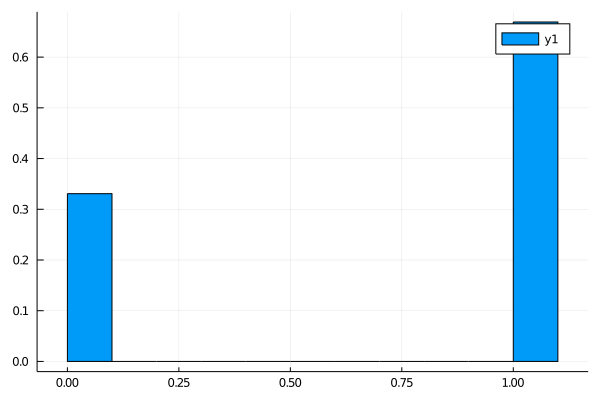

In [25]:
run_alice_and_bob_theory_of_mind(alice_2, bob_2, 1)

### depth = 2

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


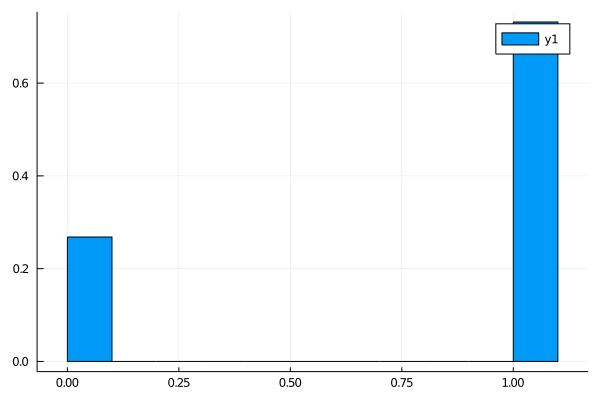

In [26]:
run_alice_and_bob_theory_of_mind(alice_2, bob_2, 2)

### depth = 5

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


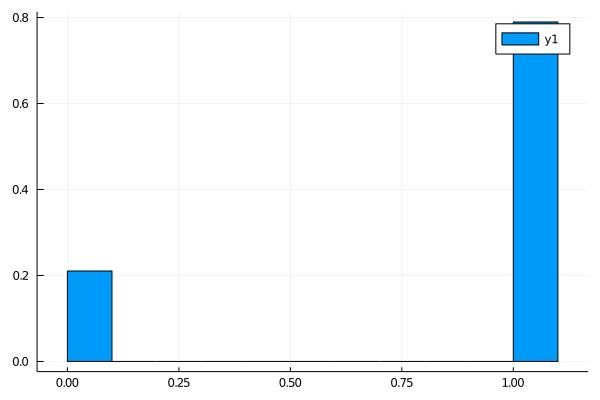

In [27]:
run_alice_and_bob_theory_of_mind(alice_2, bob_2, 5)

### depth = 10

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

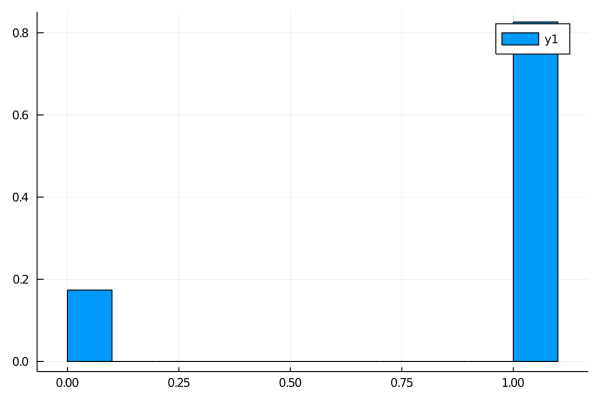

In [28]:
run_alice_and_bob_theory_of_mind(alice_2, bob_2, 10)

### depth = 20

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 

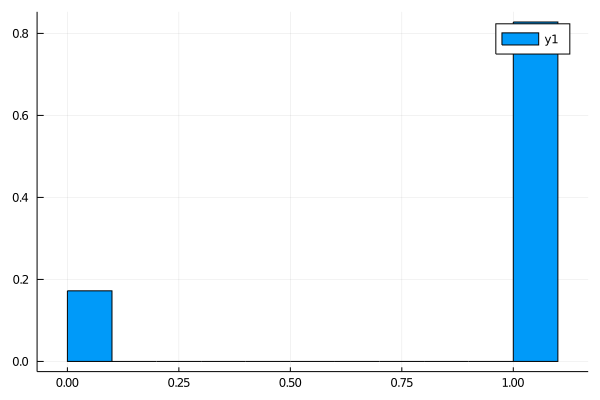

In [29]:
run_alice_and_bob_theory_of_mind(alice_2, bob_2, 20)

### TODO : max = 1

TODO: PLOT once on same figure

## TODO: try some more algorithms